In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('./origen.csv')
test = pd.read_csv('./testear.csv')

# Analisis Exploratorio

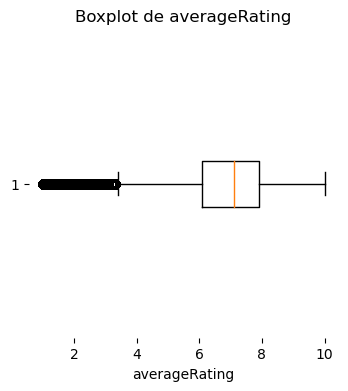

In [3]:
plt.figure(figsize=(4, 4)) 
plt.boxplot(df['averageRating'], vert=False)  
plt.title('Boxplot de averageRating')  
plt.xlabel('averageRating')  
plt.box(False)
plt.show()

In [4]:
def extract_and_join_names(row):
    if pd.notna(row):  
        cleaned_json = row.replace("'", '"').strip() 
        try:
            country_list = json.loads(cleaned_json)
            names = [country['name'] for country in country_list]
            return ', '.join(names)
        except json.JSONDecodeError as e:
            return 'Invalid JSON'
    else:
        return ''

In [5]:
df['genre_y'] = df['genres_y'].apply(extract_and_join_names)
test['genre_y'] = test['genres_y'].apply(extract_and_join_names)

In [6]:
df['countries'] = df['production_countries'].apply(extract_and_join_names)
test['countries'] = test['production_countries'].apply(extract_and_join_names)

In [7]:
df['companies'] = df['production_companies'].apply(extract_and_join_names)
test['companies'] = test['production_companies'].apply(extract_and_join_names)

# Limpieza de datos
## Variables de tipo numericas
- average rating
- numVotes
- isAdult
- startYear
- endYear
- runtimeMinutes
- seasonNumber
- episodeNumber
- ordering
- language
- isOriginalTitle
- budget
- popularity
- revenue
- runtime

## Variables de tipo str
- titleType
- genres_x
- directors
- writers
- adult
- genres_y
- original_language
- production_company
- production_country
- status
- tagline
- video

## Variables booleanas

Todas las columnas son rotuladas de manera numerica
Las columnas indice, directors, writer, tagline, language, adult fueron eliminadas

In [8]:
df = df.drop('Unnamed: 0', axis=1)

test = test.drop('Unnamed: 0', axis=1)

In [9]:
df['production_company_is_null'] = df['production_companies'].isnull().astype(int)
df['status_is_null'] = df['status'].isnull().astype(int)
df['production_countries_is_null'] = df['production_countries'].isnull().astype(int)
df['adult_is_null'] = df['adult'].isnull().astype(int)
df['genre_y_is_null'] = df['genres_y'].isnull().astype(int)
df['original_language_is_null'] = df['original_language'].isnull().astype(int)
df['video_is_null'] = df['video'].isnull().astype(int)
df['popularity_is_null'] = df['popularity'].isnull().astype(int)
df['runtime_is_null'] = df['runtime'].isnull().astype(int)
df['budget_is_null'] = df['budget'].isnull().astype(int)

test['production_company_is_null'] = test['production_companies'].isnull().astype(int)
test['status_is_null'] = test['status'].isnull().astype(int)
test['production_countries_is_null'] = test['production_countries'].isnull().astype(int)
test['adult_is_null'] = test['adult'].isnull().astype(int)
test['genre_y_is_null'] = test['genres_y'].isnull().astype(int)
test['original_language_is_null'] = test['original_language'].isnull().astype(int)
test['video_is_null'] = test['video'].isnull().astype(int)
test['popularity_is_null'] = test['popularity'].isnull().astype(int)
test['runtime_is_null'] = test['runtime'].isnull().astype(int)
test['budget_is_null'] = test['budget'].isnull().astype(int)

In [10]:
def frequency_encoder(df, test_df, column):
    frequency_map = df[column].value_counts(normalize=True).to_dict()
    df[f'{column}_freq_encoded'] = df[column].map(frequency_map)
    test_df[f'{column}_freq_encoded'] = test_df[column].map(frequency_map)

In [11]:
director_avg_votes = {}
director_max_votes = {}
director_min_votes = {}

for index, row in df.iterrows():
    directors = row['directors'].split(',')
    votes = row['numVotes']
    for director in directors:
        director_avg_votes[director] = director_avg_votes.get(director, []) + [votes]
        if director not in director_max_votes or votes > director_max_votes[director]:
            director_max_votes[director] = votes
        if director not in director_min_votes or votes < director_min_votes[director]:
            director_min_votes[director] = votes

for index, row in test.iterrows():
    directors = row['directors'].split(',')
    votes = row['numVotes']
    for director in directors:
        director_avg_votes[director] = director_avg_votes.get(director, []) + [votes]
        if director not in director_max_votes or votes > director_max_votes[director]:
            director_max_votes[director] = votes
        if director not in director_min_votes or votes < director_min_votes[director]:
            director_min_votes[director] = votes

for director, votes in director_avg_votes.items():
    director_avg_votes[director] = sum(votes) / len(votes)

df['avgVotes_directors'] = df['directors'].apply(lambda x: np.average([director_avg_votes[d] for d in x.split(',')]))
df['maxVotes_directors'] = df['directors'].apply(lambda x: max([director_max_votes[d] for d in x.split(',')]))
df['minVotes_directors'] = df['directors'].apply(lambda x: min([director_min_votes[d] for d in x.split(',')]))

test['avgVotes_directors'] = test['directors'].apply(lambda x: np.average([director_avg_votes[d] for d in x.split(',')]))
test['maxVotes_directors'] = test['directors'].apply(lambda x: max([director_max_votes[d] for d in x.split(',')]))
test['minVotes_directors'] = test['directors'].apply(lambda x: min([director_min_votes[d] for d in x.split(',')]))

In [12]:
writer_avg_votes = {}
writer_max_votes = {}
writer_min_votes = {}

for index, row in df.iterrows():
    writers = row['writers'].split(',')
    votes = row['numVotes']
    for writer in writers:
        writer_avg_votes[writer] = writer_avg_votes.get(writer, []) + [votes]
        if writer not in writer_max_votes or votes > writer_max_votes[writer]:
            writer_max_votes[writer] = votes
        if writer not in writer_min_votes or votes < writer_min_votes[writer]:
            writer_min_votes[writer] = votes

for index, row in test.iterrows():
    writers = row['writers'].split(',')
    votes = row['numVotes']
    for writer in writers:
        writer_avg_votes[writer] = writer_avg_votes.get(writer, []) + [votes]
        if writer not in writer_max_votes or votes > writer_max_votes[writer]:
            writer_max_votes[writer] = votes
        if writer not in writer_min_votes or votes < writer_min_votes[writer]:
            writer_min_votes[writer] = votes

for writer, votes in writer_avg_votes.items():
    writer_avg_votes[writer] = sum(votes) / len(votes)

df['avgVotes_writers'] = df['writers'].apply(lambda x: np.average([writer_avg_votes[d] for d in x.split(',')]))
df['maxVotes_writers'] = df['writers'].apply(lambda x: max([writer_max_votes[d] for d in x.split(',')]))
df['minVotes_writers'] = df['writers'].apply(lambda x: min([writer_min_votes[d] for d in x.split(',')]))

test['avgVotes_writers'] = test['writers'].apply(lambda x: np.average([writer_avg_votes[d] for d in x.split(',')]))
test['maxVotes_writers'] = test['writers'].apply(lambda x: max([writer_max_votes[d] for d in x.split(',')]))
test['minVotes_writers'] = test['writers'].apply(lambda x: min([writer_min_votes[d] for d in x.split(',')]))

In [13]:
frequency_encoder(df, test, 'writers')
frequency_encoder(df, test, 'directors')

In [14]:
print(df['writers'].str.count(',').max())
# Se pueden tener hasta 1288 escritores
df['CantEscritores'] = df['writers'].str.count(',') + 1
test['CantEscritores'] = test['writers'].str.count(',') + 1


# Se pueden tener hasta 475 directores
df['CantDirectores'] = df['directors'].str.count(',') + 1
test['CantDirectores'] = test['directors'].str.count(',') + 1

1287


In [15]:
df = df.drop('tagline', axis = 1)
test = test.drop('tagline', axis = 1)

In [16]:
def columnasDummies(df, unique_values, column):
    for value in unique_values:
        new_column_name = f"{column}_{value}" 
        df[new_column_name] = (df[column] == value).astype(int)

In [17]:
columnasDummies(df, df['adult'].unique(), 'adult')
columnasDummies(test, test['adult'].unique(), 'adult')
frequency_encoder(df, test, 'adult')

In [18]:
columnasDummies(df, df['titleType'].unique(), 'titleType')
columnasDummies(test, test['titleType'].unique(), 'titleType')
frequency_encoder(df, test, 'titleType')

In [19]:
frequency_encoder(df, test, 'attributes')

In [20]:
dummy_df = pd.get_dummies(df['original_language'], prefix='original_language', prefix_sep='_')
df = pd.concat([df, dummy_df], axis=1)

dummy_test = pd.get_dummies(test['original_language'], prefix='original_language', prefix_sep='_')
test = pd.concat([test, dummy_test], axis=1)
frequency_encoder(df, test, 'original_language')

In [21]:
columnasDummies(df, df['status'].unique(), 'status')
columnasDummies(test, test['status'].unique(), 'status')
frequency_encoder(df, test, 'status')
df = df.drop(columns=['status'])
test = test.drop(columns=['status'])

In [22]:
columnasDummies(df, df['video'].unique(), 'video')
columnasDummies(test, test['video'].unique(), 'video')
frequency_encoder(df, test, 'video')
df = df.drop(columns=['video'])
test = test.drop(columns=['video'])

In [23]:
dummiesGenreX = df['genres_x'].str.get_dummies(sep=',')
dummiesGenreX.columns = 'x' + dummiesGenreX.columns
df = pd.concat([df, dummiesGenreX], axis=1)
df['CantGenerosX'] = df['genres_x'].str.count(',') + 1

dummiesGenreX = test['genres_x'].str.get_dummies(sep=',')
dummiesGenreX.columns = 'x' + dummiesGenreX.columns
test = pd.concat([test, dummiesGenreX], axis=1)
test['CantGenerosX'] = test['genres_x'].str.count(',') + 1

frequency_encoder(df, test, 'genres_x')

In [24]:
dummiesGenreY = df['genre_y'].str.get_dummies(sep=',')
dummiesGenreY.columns = 'y' + dummiesGenreY.columns
df = pd.concat([df, dummiesGenreY], axis=1)
df['CantGenerosY'] = df['genre_y'].str.count(', ') 

dummiesGenreY = test['genre_y'].str.get_dummies(sep=',')
dummiesGenreY.columns = 'y' + dummiesGenreY.columns
test = pd.concat([test, dummiesGenreY], axis=1)
test['CantGenerosY'] = test['genre_y'].str.count(', ')

frequency_encoder(df, test, 'genre_y')

In [25]:
dummiesCountries = df['countries'].str.get_dummies(sep=', ')
df = pd.concat([df, dummiesCountries], axis=1)
df['CantPaises'] = df['countries'].str.count(', ') 

dummiesCountries = test['countries'].str.get_dummies(sep=', ')
test = pd.concat([test, dummiesCountries], axis=1)
test['CantPaises'] = test['countries'].str.count(', ')

frequency_encoder(df, test, 'countries')

In [26]:
frequency_encoder(df, test, 'companies')
df['CantCompanias'] = df['companies'].str.count(', ') 
test['CantCompanias'] = test['companies'].str.count(', ')

In [27]:
promedioGeneral = df['numVotes'].mean()
medianaGeneral = df['numVotes'].median()

df['diferenciaConMedia'] = df['numVotes'] - promedioGeneral
df['diferenciaConMediana'] = df['numVotes'] - medianaGeneral
test['diferenciaConMedia'] = test['numVotes'] - promedioGeneral
test['diferenciaConMediana'] = test['numVotes'] - medianaGeneral

In [28]:
test = test.drop(columns=['adult'])
test = test.drop(columns=['isAdult'])
df = df.drop(columns=['adult'])
df = df.drop(columns=['isAdult'])

In [29]:
test = test.drop(columns=['language'])
test = test.drop(columns=['original_language'])
df = df.drop(columns=['language'])
df = df.drop(columns=['original_language'])

In [30]:
test = test.drop(columns=['genres_x'])
df = df.drop(columns=['genres_x'])

In [31]:
test = test.drop(columns=['genre_y'])
test = test.drop(columns=['genres_y'])
df = df.drop(columns=['genre_y'])
df = df.drop(columns=['genres_y'])

In [32]:
test = test.drop(columns=['production_countries'])
test = test.drop(columns=['countries'])
df = df.drop(columns=['production_countries'])
df = df.drop(columns=['countries'])

In [33]:
test = test.drop(columns=['production_companies'])
test = test.drop(columns=['companies'])
df = df.drop(columns=['production_companies'])
df = df.drop(columns=['companies'])

In [34]:
missing_columns = list(set(df.columns) - set(test.columns))
missing_df = pd.DataFrame(0, columns=missing_columns, index=test.index)
test = pd.concat([test, missing_df], axis=1)
extra_columns = list(set(test.columns) - set(df.columns))
test = test.drop(extra_columns, axis=1)

In [35]:
df = df.drop(columns=['titleType', 'directors', 'writers', 'attributes'])
test = test.drop(columns=['titleType', 'directors', 'writers', 'attributes'])
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()

print("Columnas no numéricas en el DataFrame:")
print(non_numeric_columns)

Columnas no numéricas en el DataFrame:
[]


In [36]:
df.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# Modelos Predictivos 

In [37]:
X = df.drop(['averageRating'], axis=1)
y = df['averageRating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [44]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train = df.drop('averageRating', axis=1)
y_train = df['averageRating']

X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

reg_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=15, reg_lambda=0, reg_alpha=2, random_state=13)

reg_model.fit(X_train, y_train)

y_pred_eval = reg_model.predict(X_eval)

mse = mean_squared_error(y_eval, y_pred_eval)
print(f"Mean Squared Error on Evaluation Set: {mse}")

r2 = r2_score(y_eval, y_pred_eval)
print(f"Coeficiente de determinación (R2) on Evaluation Set: {r2}")

test = test.reindex(columns=X_train.columns, fill_value=0)

test_predictions = reg_model.predict(test)

prediction_df = pd.DataFrame({'Id': test.index, 'Predicted_averageRating': test_predictions})

prediction_df.to_csv('predictions.csv', index=False)

Mean Squared Error on Evaluation Set: 0.9775749307824022
Coeficiente de determinación (R2) on Evaluation Set: 0.5016486867583072


# Extra Tree Regressor

In [45]:
extra = ExtraTreesRegressor(max_depth= 40, min_samples_split=13, n_estimators=2000, bootstrap=True) 
extra.fit(X_train, y_train)     

In [ ]:
columnasSinTarget = [col for col in df.columns if col != 'averageRating']
resultado = extra.predict(test[columnasSinTarget])

prediction_df = pd.DataFrame({'Id': test.index, 'Predicted_averageRating': resultado})

prediction_df.to_csv('predictionextratrees.csv', index=False)

# Random Forest

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

X_train = pd.DataFrame(X_train, columns=X.columns)
reg_model = RandomForestRegressor(n_estimators=1000, random_state=13) 
reg_model.fit(X_train, y_train)

In [ ]:
y_pred_eval = reg_model.predict(X_eval)
mse = mean_squared_error(y_eval, y_pred_eval)
print(f"Mean Squared Error on Evaluation Set: {mse}")

r2 = r2_score(y_eval, y_pred_eval)
print(f"Coeficiente de determinación (R2) on Evaluation Set: {r2}")

test = test.reindex(columns=X.columns, fill_value=0)
test_predictions = reg_model.predict(test)

prediction_df = pd.DataFrame({'Id': test.index, 'Predicted_averageRating': test_predictions})
prediction_df.to_csv('predictions.csv', index=False)

Mean Squared Error on Evaluation Set: 1.0222340169823911
Coeficiente de determinación (R2) on Evaluation Set: 0.4808193713932759
